In [1]:
# Import the necessary packages
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Read in the data
def stockData(stockList):
    iteration = 0
    for stocks in stockList:
        match iteration:
            case 0:
                stockDf = pd.read_csv(
                    stocks,
                    parse_dates=["Date"],
                    infer_datetime_format=True,
                    index_col="Date",
                    dayfirst=True,
                )
                iteration = 1
                pass
            case 1:
                stockDf[stocks.split('/')[-1].split('.')[0]] = pd.read_csv(
                    stocks,
                    parse_dates=["Date"],
                    infer_datetime_format=True,
                    index_col="Date",
                    dayfirst=True,
                )["Close"]
                stockDf[stockList[0].split('/')[-1].split('.')[0]] = stockDf["Close"]
                stockDf = stockDf.loc[:, list(map(lambda x: x.split('/')[-1].split('.')[0], stockList[:2]))[:2]]
                iteration = 2
                pass
            case 2:
                stockDf[stocks.split('/')[-1].split('.')[0]] = pd.read_csv(
                    stocks,
                    parse_dates=["Date"],
                    infer_datetime_format=True,
                    index_col="Date",
                    dayfirst=True,
                )["Close"]
                pass
        pass
    if len(stockList) < 2:
        stockDf[stockList[0].split('/')[-1].split('.')[0]] = stockDf["Close"]
        return stockDf[stockList[0].split('/')[-1].split('.')[0]]
    else:
        return stockDf.dropna()


In [3]:
# Transform data to %Change returns
def pctChange(stockDf):
    for eachCol in stockDf:
        stockDf[eachCol] = stockDf[eachCol] / stockDf[eachCol].shift() - 1
        pass
    return stockDf.dropna()

In [4]:
# Define the scale data function:
def scaleData(data, portfolioProportions):
    # Scale the data
    scaledData = data.copy()
    for eachStock in scaledData:
        scaledData[eachStock] = data[eachStock] * portfolioProportions[eachStock]
        pass
    return scaledData

In [5]:
# Calculate the average return of the portfolio
def averageReturn(scaledData):
    return scaledData.sum(axis=1).mean()

In [6]:
# Calculate the risk of the portfolio
def expectedRisk(scaledData):
    return scaledData.sum(axis=1).std()

In [7]:
# Analyze the risk and return of 500 random portfolios in the stock list
def portfolioAnalysis(stockList, randomPortfolios=500):
    # Read in the data
    data = pctChange(stockData(stockList))
    # Make an empty list of empty dictionaries
    portfolioProportions = [{} for i in range(randomPortfolios)]
    averageReturns = []
    expectedRisks = []
    # Make 500 random portfolios from the stock list
    for portfolios in range(0, randomPortfolios):
        remainder = 1.0
        for eachStock in data.columns[:-1]:
            proportion = round(random.uniform(0, remainder - 0.01), 2)
            portfolioProportions[portfolios][eachStock] = proportion
            remainder = remainder - proportion
            pass
        portfolioProportions[portfolios][data.columns[-1]] = round(remainder, 2)
        pass
        # Scale the data based on the portfolio proportions
        scaledData = scaleData(data, portfolioProportions[portfolios])
        # Get average return and risk for each portfolio
        averageReturns.append(averageReturn(scaledData))
        expectedRisks.append(expectedRisk(scaledData))
        pass
    return pd.DataFrame(
        {
            "Average Return": averageReturns,
            "Expected Risk": expectedRisks,
            "Portfolio Make-up": portfolioProportions,
        }
    )

In [8]:
# Subset the portfolios near the efficient frontier
def efficientFrontier(portfolioDF):
    portfolioDF["Risk Return Ratio"] = (
        portfolioDF.loc[:, "Average Return"] / portfolioDF.loc[:, "Expected Risk"]
    )
    return portfolioDF.sort_values("Risk Return Ratio", ascending=False).head(15)

In [9]:
# Plot the risk and return of the portfolios
def plotPortfolios(portfolioDF):
    portfolioDF.plot.scatter(x = "Expected Risk", y = "Average Return", figsize = (10, 8), xlabel = "Expected Risk", ylabel = "Average Return", title = "Risk and Return of Portfolios")

In [10]:
stocks = ['AAPL', 'GOOG']

In [11]:
files = []
for path in stocks:
    x = !find . -name {path}.csv | head -1
    files.append(x[0])

/home/codespace/.local/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


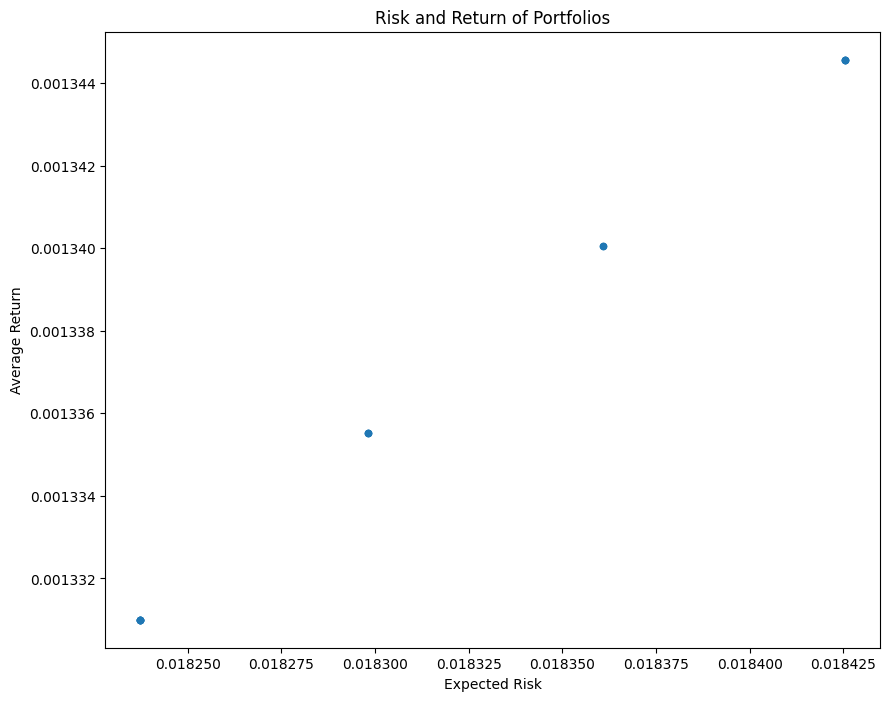

In [12]:
plotPortfolios(efficientFrontier(portfolioAnalysis(files)))